In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from library.evaluation import ConfusionMatrix

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

dataset_name = "Phemernr2-TF"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(1705, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr2-tf_dataset.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,topic,tvt2
0,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,True,germanwings-crash-all-rnr-threads,training
1,552798891994009601,Reports that two of the dead in the #CharlieHe...,True,charliehebdo-all-rnr-threads,training
2,580352540316946432,'No survivors' in #Germanwings crash says Fren...,False,germanwings-crash-all-rnr-threads,training
3,524983403775799297,Tragedy mounts as soldier shot this AM dies of...,True,ottawashooting-all-rnr-threads,training
4,544511915158810624,Watch the moment gunfire and explosions were h...,True,sydneysiege-all-rnr-threads,training


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
    labels.append(lab)
labels[:10]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1176, 768)
(371, 768)
(158, 768)
(1176,)
(371,)
(158,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1547, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1547,)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input, n_output)

    
def ResNet18(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input, n_output)


def ResNet34(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet50(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet101(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input, n_output)


def ResNet152(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input, n_output)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CNNResNet10(n_output: int):
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1], n_output)

    
def CNNResNet18(n_output: int):
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2], n_output)


def CNNResNet34(n_output: int):
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3], n_output)


def CNNResNet50(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3], n_output)


def CNNResNet101(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3], n_output)


def CNNResNet152(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3], n_output)

In [12]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()


            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    
                    if self.model_type == 'mlp':
                        outputs = self.model(inputs)
                    else:
    #                     outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                        outputs = self.model(inputs.unsqueeze(1))

                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()

                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                    # if self.model_type == 'mlp':
                    #     preds = self.predict(test_x)
                    # else:
                    #     preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                    # conf_mat = ConfusionMatrix(
                    #     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    #     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    #     binary=False
                    # )
                    # conf_mat.evaluate(logs=False)
                    # test_acc = conf_mat.accuracy
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break

         # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

--- FOLD 1 ----
Multiclass Classification Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1
Using cuda
Saving after new best accuracy : 37.41935483870968
Saving after new best accuracy : 87.41935483870968
Saving after new best accuracy : 97.09677419354838
Saving after new best accuracy : 97.74193548387096
Saving after new best accuracy : 98.06451612903226
Saving after new best accuracy : 98.38709677419355
Saving after new best accuracy : 98.70967741935483
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 98.70967741935483, Train Loss : 0.008320971624925733, Validation Loss : 0.044603727757930756
Saving after new best accuracy : 99.03225806451613
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 99.03225806451613, Train Loss : 0.0023780714254826307, Validation Loss : 0.048715800046920776
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 99.03225806451613, Train Loss : 0.0011384350073058158, Validation Loss : 0.051738057285547256
-- Epoch 200, Train_Accuracy 

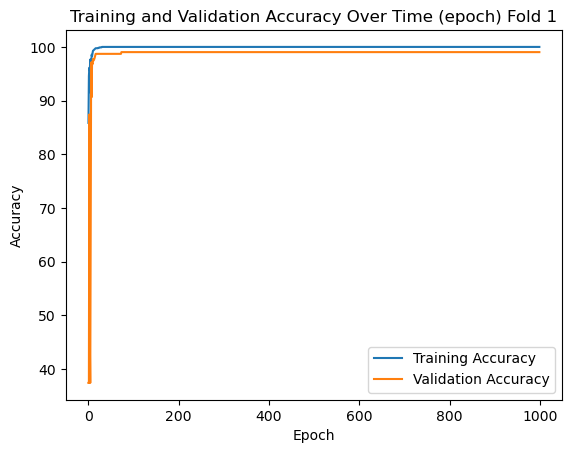

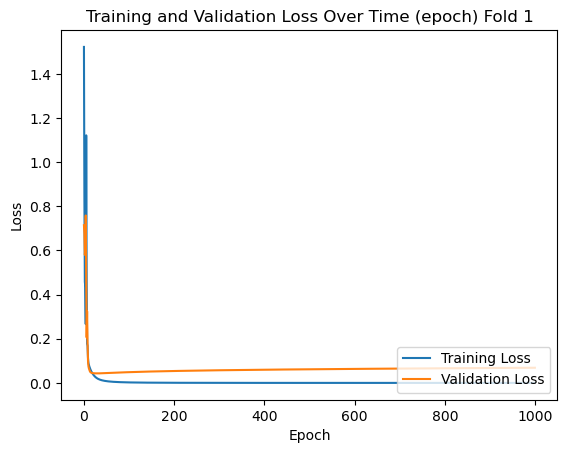

Exec Time : 177.4 seconds

---- Train Set ----
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 461
False Positive : 0
False Negative : 0
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  0 461]]


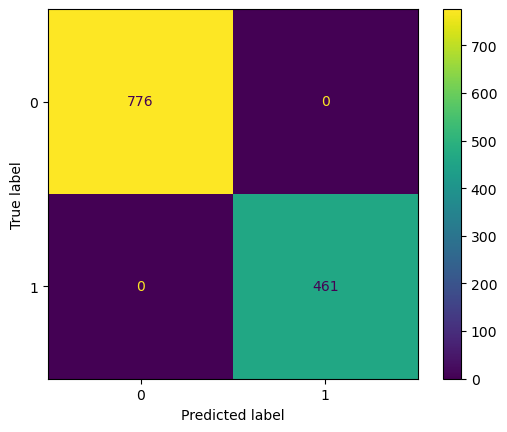


---- Validation Set ----
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 113
False Positive : 0
False Negative : 3
True Negative : 194

Class False Evaluation
- Precision : 100.0 %
- Recall : 97.414 %
- F1 : 0.9869

Class True Evaluation
- Precision : 98.477 %
- Recall : 100.0 %
- F1 : 0.99233

Combined Evaluation
- Accuracy : 99.032 %
- Precision : 99.239 %
- Recall : 98.707 %
- F1 : 0.98972
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Validation, 99.032, 99.239, 98.707, 0.98972, 100.0, 97.414, 0.9869, 98.477, 100.0, 0.99233, 
Confusion Matrix Scikit-learn: 
[[194   0]
 [  3 113]]


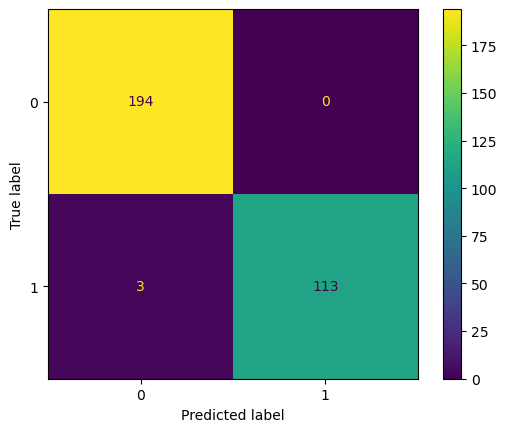


---- Test Set ----
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 52
False Positive : 9
False Negative : 9
True Negative : 88

Class False Evaluation
- Precision : 85.246 %
- Recall : 85.246 %
- F1 : 0.85246

Class True Evaluation
- Precision : 90.722 %
- Recall : 90.722 %
- F1 : 0.90722

Combined Evaluation
- Accuracy : 88.608 %
- Precision : 87.984 %
- Recall : 87.984 %
- F1 : 0.87984
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Test, 88.608, 87.984, 87.984, 0.87984, 85.246, 85.246, 0.85246, 90.722, 90.722, 0.90722, 
158
158
Confusion Matrix Scikit-learn: 
[[88  9]
 [ 9 52]]


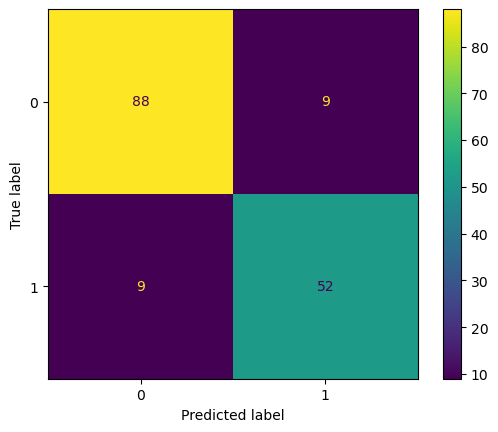

--- FOLD 2 ----
Multiclass Classification Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2
Using cuda
Saving after new best accuracy : 37.41935483870968
Saving after new best accuracy : 44.83870967741935
Saving after new best accuracy : 89.03225806451613
Saving after new best accuracy : 92.90322580645162
Saving after new best accuracy : 97.41935483870968
Saving after new best accuracy : 97.74193548387096
Saving after new best accuracy : 98.06451612903226
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 98.06451612903226, Train Loss : 0.0082868377212435, Validation Loss : 0.058046482503414154
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 98.06451612903226, Train Loss : 0.0022886274964548647, Validation Loss : 0.06088133901357651
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 98.06451612903226, Train Loss : 0.0010803812183439732, Validation Loss : 0.06325595825910568
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 98.06451612903226, Train

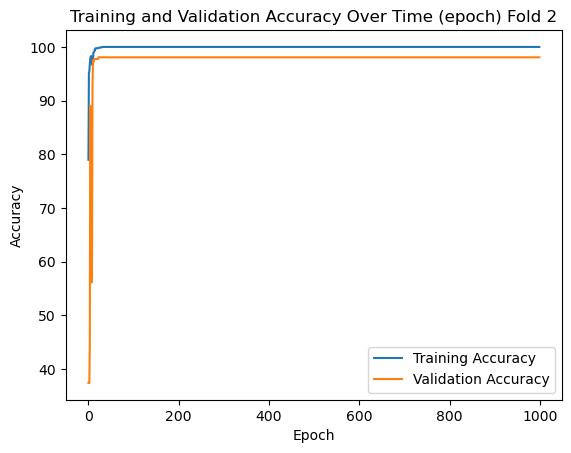

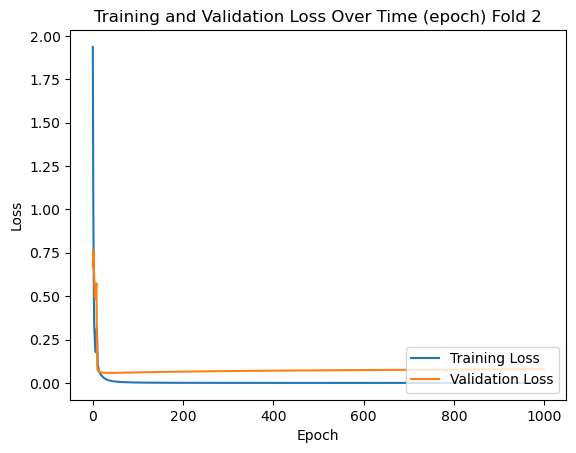

Exec Time : 174.34 seconds

---- Train Set ----
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 459
False Positive : 0
False Negative : 2
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 99.566 %
- F1 : 0.99783

Class True Evaluation
- Precision : 99.743 %
- Recall : 100.0 %
- F1 : 0.99871

Combined Evaluation
- Accuracy : 99.838 %
- Precision : 99.871 %
- Recall : 99.783 %
- F1 : 0.99827
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Train, 99.838, 99.871, 99.783, 0.99827, 100.0, 99.566, 0.99783, 99.743, 100.0, 0.99871, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  2 459]]


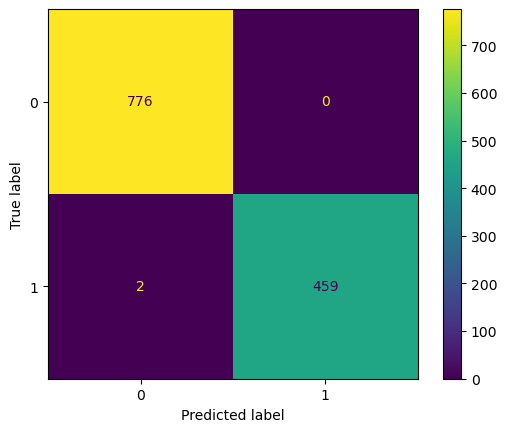


---- Validation Set ----
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 114
False Positive : 4
False Negative : 2
True Negative : 190

Class False Evaluation
- Precision : 96.61 %
- Recall : 98.276 %
- F1 : 0.97436

Class True Evaluation
- Precision : 98.958 %
- Recall : 97.938 %
- F1 : 0.98446

Combined Evaluation
- Accuracy : 98.065 %
- Precision : 97.784 %
- Recall : 98.107 %
- F1 : 0.97945
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Validation, 98.065, 97.784, 98.107, 0.97945, 96.61, 98.276, 0.97436, 98.958, 97.938, 0.98446, 
Confusion Matrix Scikit-learn: 
[[190   4]
 [  2 114]]


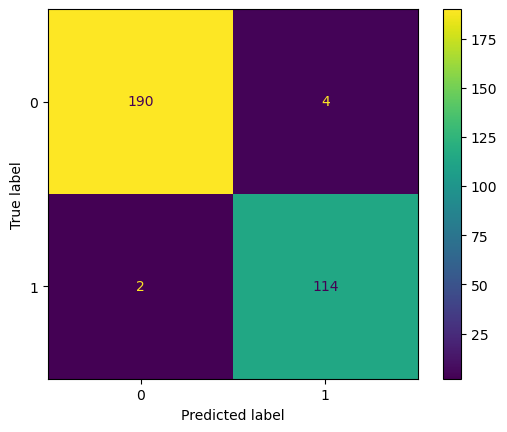


---- Test Set ----
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 10
False Negative : 8
True Negative : 87

Class False Evaluation
- Precision : 84.127 %
- Recall : 86.885 %
- F1 : 0.85484

Class True Evaluation
- Precision : 91.579 %
- Recall : 89.691 %
- F1 : 0.90625

Combined Evaluation
- Accuracy : 88.608 %
- Precision : 87.853 %
- Recall : 88.288 %
- F1 : 0.8807
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Test, 88.608, 87.853, 88.288, 0.8807, 84.127, 86.885, 0.85484, 91.579, 89.691, 0.90625, 
158
158
Confusion Matrix Scikit-learn: 
[[87 10]
 [ 8 53]]


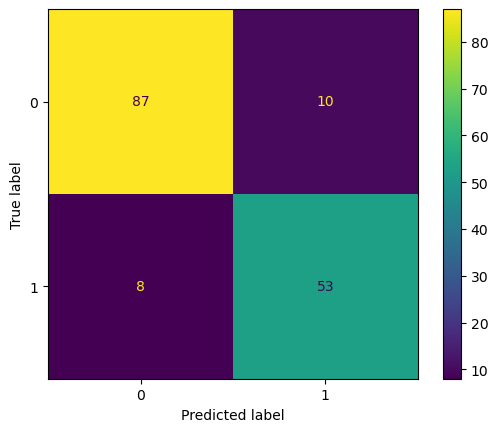

--- FOLD 3 ----
Multiclass Classification Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3
Using cuda
Saving after new best accuracy : 57.92880258899677
Saving after new best accuracy : 91.90938511326861
Saving after new best accuracy : 93.20388349514563
Saving after new best accuracy : 95.79288025889967
Saving after new best accuracy : 97.41100323624596
Saving after new best accuracy : 97.73462783171522
Saving after new best accuracy : 98.05825242718447
Saving after new best accuracy : 98.38187702265373
Saving after new best accuracy : 98.70550161812298
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 98.70550161812298, Train Loss : 0.009203441208228469, Validation Loss : 0.03390287980437279
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 98.70550161812298, Train Loss : 0.0025298825348727405, Validation Loss : 0.033244360238313675
Saving after new best accuracy : 99.02912621359224
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 99.02912621359224, Tra

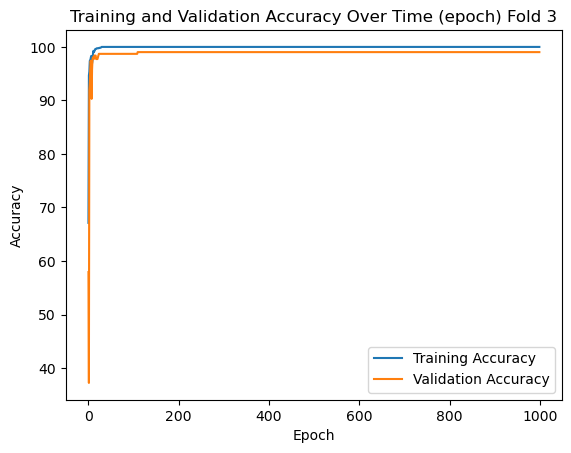

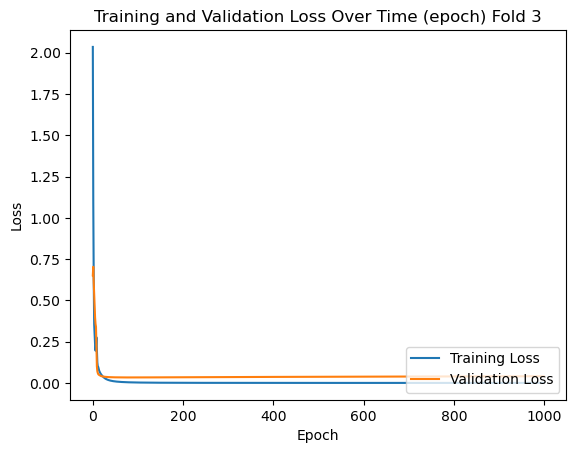

Exec Time : 174.83 seconds

---- Train Set ----
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 462
False Positive : 0
False Negative : 0
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  0 462]]


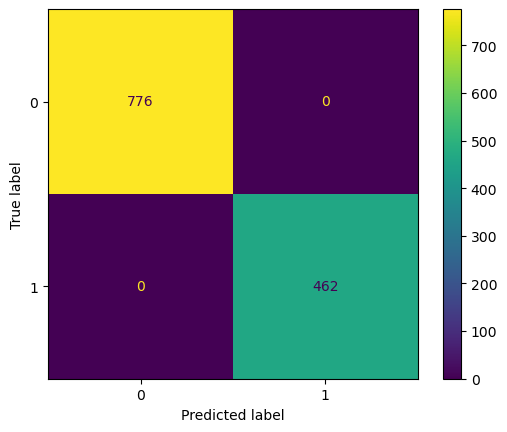


---- Validation Set ----
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 112
False Positive : 0
False Negative : 3
True Negative : 194

Class False Evaluation
- Precision : 100.0 %
- Recall : 97.391 %
- F1 : 0.98678

Class True Evaluation
- Precision : 98.477 %
- Recall : 100.0 %
- F1 : 0.99233

Combined Evaluation
- Accuracy : 99.029 %
- Precision : 99.239 %
- Recall : 98.696 %
- F1 : 0.98967
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Validation, 99.029, 99.239, 98.696, 0.98967, 100.0, 97.391, 0.98678, 98.477, 100.0, 0.99233, 
Confusion Matrix Scikit-learn: 
[[194   0]
 [  3 112]]


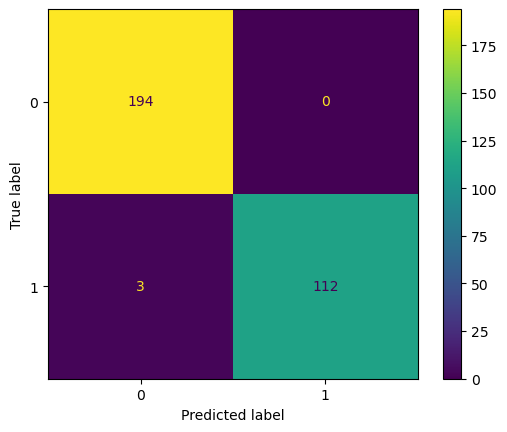


---- Test Set ----
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 9
False Negative : 8
True Negative : 88

Class False Evaluation
- Precision : 85.484 %
- Recall : 86.885 %
- F1 : 0.86179

Class True Evaluation
- Precision : 91.667 %
- Recall : 90.722 %
- F1 : 0.91192

Combined Evaluation
- Accuracy : 89.241 %
- Precision : 88.575 %
- Recall : 88.803 %
- F1 : 0.88689
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Test, 89.241, 88.575, 88.803, 0.88689, 85.484, 86.885, 0.86179, 91.667, 90.722, 0.91192, 
158
158
Confusion Matrix Scikit-learn: 
[[88  9]
 [ 8 53]]


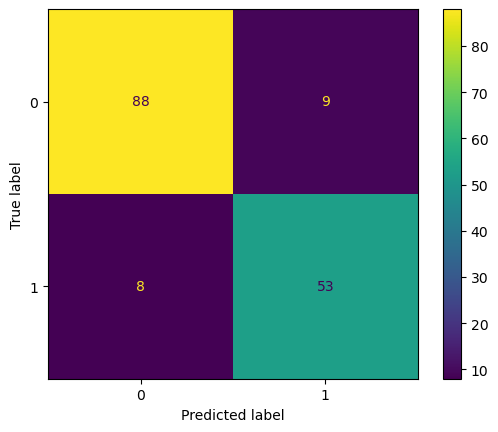

--- FOLD 4 ----
Multiclass Classification Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4
Using cuda
Saving after new best accuracy : 37.2168284789644
Saving after new best accuracy : 83.49514563106796
Saving after new best accuracy : 88.02588996763754
Saving after new best accuracy : 95.46925566343042
Saving after new best accuracy : 95.79288025889967
Saving after new best accuracy : 98.05825242718447
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 97.73462783171522, Train Loss : 0.008868158096447587, Validation Loss : 0.1108020544052124
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 97.73462783171522, Train Loss : 0.002568502852227539, Validation Loss : 0.1235312670469284
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 97.73462783171522, Train Loss : 0.0012334309867583215, Validation Loss : 0.13223186135292053
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 97.73462783171522, Train Loss : 0.0007285122410394251, Validation Loss : 0.138

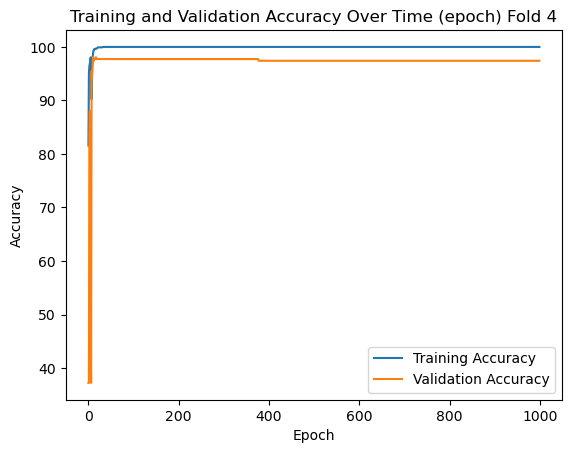

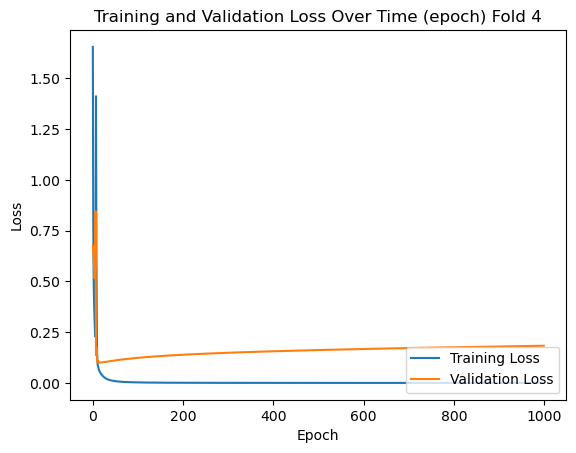

Exec Time : 173.2 seconds

---- Train Set ----
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 449
False Positive : 3
False Negative : 13
True Negative : 773

Class False Evaluation
- Precision : 99.336 %
- Recall : 97.186 %
- F1 : 0.98249

Class True Evaluation
- Precision : 98.346 %
- Recall : 99.613 %
- F1 : 0.98976

Combined Evaluation
- Accuracy : 98.708 %
- Precision : 98.841 %
- Recall : 98.4 %
- F1 : 0.9862
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Train, 98.708, 98.841, 98.4, 0.9862, 99.336, 97.186, 0.98249, 98.346, 99.613, 0.98976, 
Confusion Matrix Scikit-learn: 
[[773   3]
 [ 13 449]]


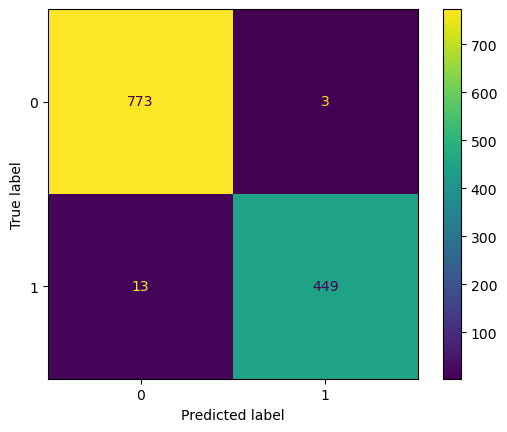


---- Validation Set ----
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 113
False Positive : 4
False Negative : 2
True Negative : 190

Class False Evaluation
- Precision : 96.581 %
- Recall : 98.261 %
- F1 : 0.97414

Class True Evaluation
- Precision : 98.958 %
- Recall : 97.938 %
- F1 : 0.98446

Combined Evaluation
- Accuracy : 98.058 %
- Precision : 97.77 %
- Recall : 98.1 %
- F1 : 0.97935
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Validation, 98.058, 97.77, 98.1, 0.97935, 96.581, 98.261, 0.97414, 98.958, 97.938, 0.98446, 
Confusion Matrix Scikit-learn: 
[[190   4]
 [  2 113]]


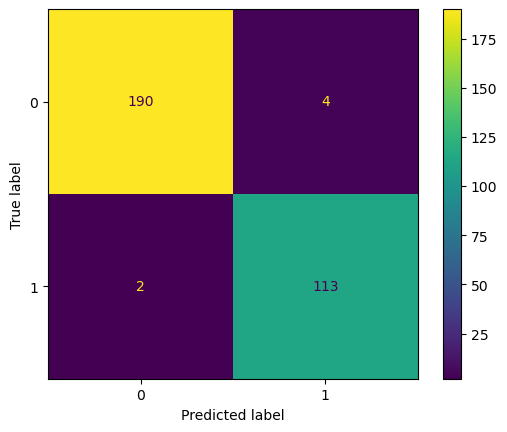


---- Test Set ----
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 52
False Positive : 10
False Negative : 9
True Negative : 87

Class False Evaluation
- Precision : 83.871 %
- Recall : 85.246 %
- F1 : 0.84553

Class True Evaluation
- Precision : 90.625 %
- Recall : 89.691 %
- F1 : 0.90155

Combined Evaluation
- Accuracy : 87.975 %
- Precision : 87.248 %
- Recall : 87.468 %
- F1 : 0.87358
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Test, 87.975, 87.248, 87.468, 0.87358, 83.871, 85.246, 0.84553, 90.625, 89.691, 0.90155, 
158
158
Confusion Matrix Scikit-learn: 
[[87 10]
 [ 9 52]]


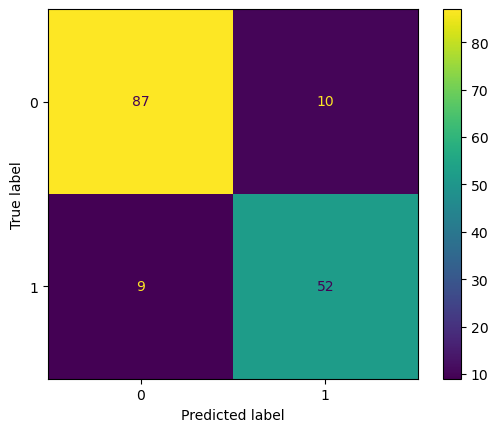

--- FOLD 5 ----
Multiclass Classification Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5
Using cuda
Saving after new best accuracy : 87.70226537216828
Saving after new best accuracy : 89.32038834951456
Saving after new best accuracy : 90.29126213592232
Saving after new best accuracy : 90.93851132686085
Saving after new best accuracy : 91.2621359223301
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 90.93851132686085, Train Loss : 0.004433544585481286, Validation Loss : 0.4533991515636444
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 0.0012795374495908618, Validation Loss : 0.5234357714653015
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 0.0006178955372888595, Validation Loss : 0.5657027959823608
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 0.00036674451257567853, Validation Loss : 0.5962436199188232
-- Epoch 250, Train_Accuracy : 100.0

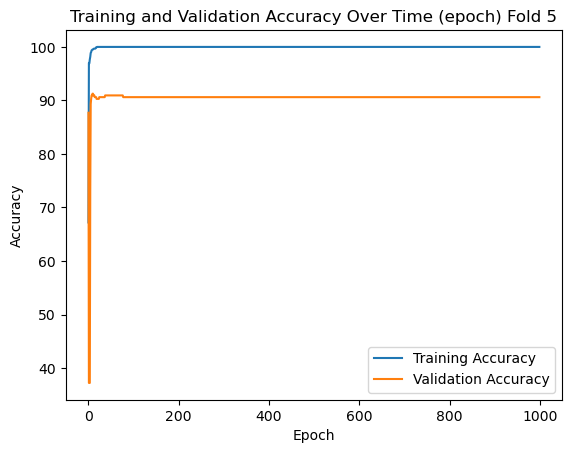

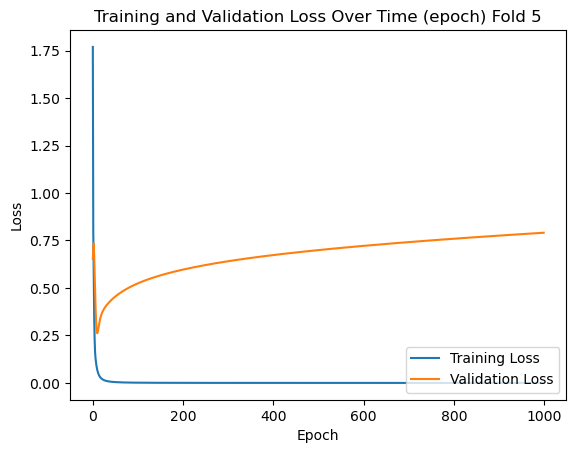

Exec Time : 174.38 seconds

---- Train Set ----
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 455
False Positive : 4
False Negative : 7
True Negative : 772

Class False Evaluation
- Precision : 99.129 %
- Recall : 98.485 %
- F1 : 0.98806

Class True Evaluation
- Precision : 99.101 %
- Recall : 99.485 %
- F1 : 0.99293

Combined Evaluation
- Accuracy : 99.111 %
- Precision : 99.115 %
- Recall : 98.985 %
- F1 : 0.9905
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Train, 99.111, 99.115, 98.985, 0.9905, 99.129, 98.485, 0.98806, 99.101, 99.485, 0.99293, 
Confusion Matrix Scikit-learn: 
[[772   4]
 [  7 455]]


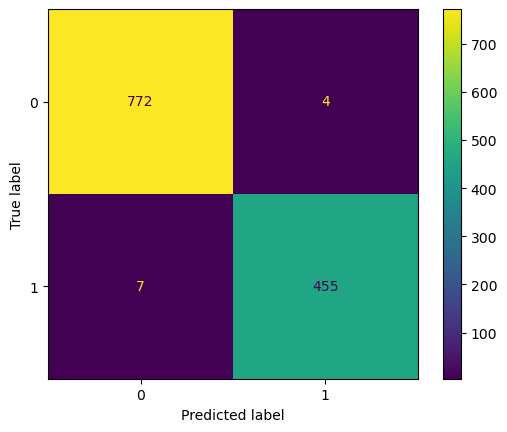


---- Validation Set ----
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 94
False Positive : 6
False Negative : 21
True Negative : 188

Class False Evaluation
- Precision : 94.0 %
- Recall : 81.739 %
- F1 : 0.87442

Class True Evaluation
- Precision : 89.952 %
- Recall : 96.907 %
- F1 : 0.933

Combined Evaluation
- Accuracy : 91.262 %
- Precision : 91.976 %
- Recall : 89.323 %
- F1 : 0.9063
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Validation, 91.262, 91.976, 89.323, 0.9063, 94.0, 81.739, 0.87442, 89.952, 96.907, 0.933, 
Confusion Matrix Scikit-learn: 
[[188   6]
 [ 21  94]]


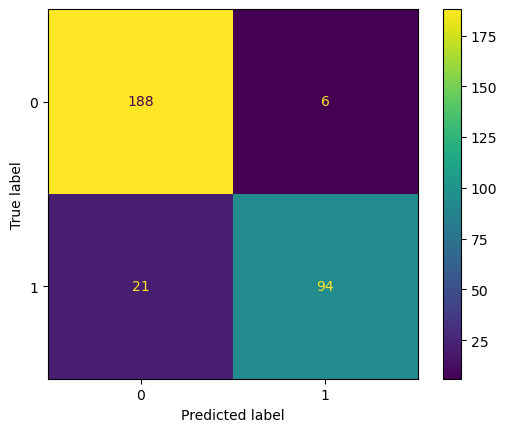


---- Test Set ----
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 7
False Negative : 8
True Negative : 90

Class False Evaluation
- Precision : 88.333 %
- Recall : 86.885 %
- F1 : 0.87603

Class True Evaluation
- Precision : 91.837 %
- Recall : 92.784 %
- F1 : 0.92308

Combined Evaluation
- Accuracy : 90.506 %
- Precision : 90.085 %
- Recall : 89.834 %
- F1 : 0.89959
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Test, 90.506, 90.085, 89.834, 0.89959, 88.333, 86.885, 0.87603, 91.837, 92.784, 0.92308, 
158
158
Confusion Matrix Scikit-learn: 
[[90  7]
 [ 8 53]]


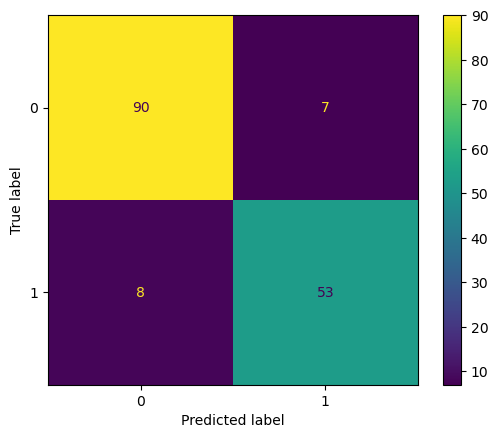

In [14]:
for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
    
    model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}_Fold{i+1}"
    start = time.time()
    print(f"Multiclass Classification {model_name}")
    model = ResNetClassifier(CNNResNet10(n_output=2), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
    model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\n---- Train Set ----")
    preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Validation Set ----")
    preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Test Set ----")
    preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

In [15]:
# model_name = f"{dataset_name}_ResNet18_CNN_{unique_name}"
# start = time.time()
# print(f"Multiclass Classification {model_name}")
# model = ResNetClassifier(CNNResNet18(n_output=4), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=512)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# print("\n---- Train Set ----")
# preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(train_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Train"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(train_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Validation Set ----")
# preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(val_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Validation"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(val_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Test Set ----")
# preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(test_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Test"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(test_labels)
# predictions=np.array(preds)
# print(len(labels))
# print(len(predictions))
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()